In [ ]:
# Name: Wenqi Wang
# Github username: acse-ww721

## Basic import

In [1]:
# Basic setting for Jupyter_notebook to import utils
import os
import sys

notebook_path = os.path.abspath("")
project_root = os.path.abspath(os.path.join(notebook_path, "../../"))

sys.path.append(project_root)

In [2]:
import os
import xarray as xr
import numpy as np
import pandas as pd
from tqdm import tqdm
from datetime import datetime, timedelta
from utils import folder_utils

In [3]:
''' 

@author: Ashesh Chattopadhyay
This is a hybird SPEnKF implementation with U-STNx as the backgroud forecast model.

More details in paper: https://gmd.copernicus.org/preprints/gmd-2021-71/

The github repository contains an jupyter notebook to train the U-STNx model with different values of "x"



'''

import numpy as np
import netCDF4 as nc
import scipy.io as sio

In [4]:
def get_era5_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.find_folder(
        country, data_folder, data_category, output_folder
    )
    nc_files = [
        f for f in os.listdir(input_folder_path) if f.endswith(".nc")
    ]
    return [
        os.path.join(input_folder_path, nc_file) for nc_file in nc_files
    ]  # list for era5 nc files path

In [5]:
#### SPNEKF implementation following Tyrus Berry's implementation ######

def ENKF(x, n, P ,Q, R, obs, model, u_ensemble):
    print("obs\n")
    obs=np.reshape(obs,[n,1]) 
    print("x\n")
    x=np.reshape(x,[n,1])
    print("USV\n")
    [U,S,V]=np.linalg.svd(P)
    print("D\n")
    D=np.zeros([n,n])
    print("diagonal\n")
    np.fill_diagonal(D,S)
    print("sqrtP\n")
    sqrtP=np.dot(np.dot(U,np.sqrt(D)),U)
    print("ens1\n")
    ens=np.zeros([n,2*n])
    print("ens2\n")
    ens[:,0:n]=np.tile(x,(1,n)) + sqrtP
    print("ens3\n")
    ens[:,n:]=np.tile(x,(1,n)) - sqrtP
    ## forecasting step,dummy model

    for k in range(0, np.size(ens,1)):

       u =  model.predict(np.reshape(ens[:,k],[1, 32, 64, 1]))

       u_ensemble[:,k]=np.reshape(u,(32*64,))



    ############################
    print("x_prior\n")
    x_prior = np.reshape(np.mean(u_ensemble,1),[n,1])
    print('shape pf x_prior',np.shape(x_prior))
    print('shape pf obs',np.shape(obs))
    print("cf_ens\n")
    cf_ens = ens - np.tile(x_prior,(1,2*n))
    print("P_prior\n")
    P_prior = np.dot(cf_ens,np.transpose(cf_ens))/(2*n - 1)+Q
    print("h_ens\n")
    h_ens = ens
    print("y_prior\n")
    y_prior=np.reshape(np.mean(h_ens,1),[n,1])
    ch_ens = h_ens - np.tile(y_prior,(1,2*n))
    print('shape pf y_prior',np.shape(y_prior))
    print("P_y\n")
    P_y = np.dot(ch_ens, np.transpose(ch_ens))/(2*n-1) + R
    print("P_xy\n")
    P_xy = np.dot(cf_ens, np.transpose(ch_ens)) /(2*n-1)
    print("K\n")
    K = np.dot(P_xy,np.linalg.inv(P_y))
    print("P\n")
    P = P_prior - np.dot(np.dot(K,P_y),np.transpose(K))
    print("x\n")
    x = x_prior + np.dot(K,(obs-y_prior))

    return x, P

In [6]:
def get_initial_weights(output_size):
    b = np.zeros((2, 3), dtype='float32')
    b[0, 0] = 1
    b[1, 1] = 1
    W = np.zeros((output_size, 6), dtype='float32')
    weights = [W, b.flatten()]
    return weights

In [7]:
from keras import backend as K
from keras.engine.topology import Layer

if K.backend() == 'tensorflow':
    import tensorflow as tf

    def K_meshgrid(x, y):
        return tf.meshgrid(x, y)

    def K_linspace(start, stop, num):
        return tf.linspace(start, stop, num)

else:
    raise Exception("Only 'tensorflow' is supported as backend")


class BilinearInterpolation(Layer):
    """Performs bilinear interpolation as a keras layer
    References
    ----------
    [1]  Spatial Transformer Networks, Max Jaderberg, et al.
    [2]  https://github.com/skaae/transformer_network
    [3]  https://github.com/EderSantana/seya
    """

    def __init__(self, output_size, **kwargs):
        self.output_size = output_size
        super(BilinearInterpolation, self).__init__(**kwargs)

    def get_config(self):
        return {
            'output_size': self.output_size,
        }

    def compute_output_shape(self, input_shapes):
        height, width = self.output_size
        num_channels = input_shapes[0][-1]
        return (None, height, width, num_channels)

    def call(self, tensors, mask=None):
        X, transformation = tensors
        output = self._transform(X, transformation, self.output_size)
        return output

    def _interpolate(self, image, sampled_grids, output_size):

        batch_size = K.shape(image)[0]
        height = K.shape(image)[1]
        width = K.shape(image)[2]
        num_channels = K.shape(image)[3]

        x = K.cast(K.flatten(sampled_grids[:, 0:1, :]), dtype='float32')
        y = K.cast(K.flatten(sampled_grids[:, 1:2, :]), dtype='float32')

        x = .5 * (x + 1.0) * K.cast(width, dtype='float32')
        y = .5 * (y + 1.0) * K.cast(height, dtype='float32')

        x0 = K.cast(x, 'int32')
        x1 = x0 + 1
        y0 = K.cast(y, 'int32')
        y1 = y0 + 1

        max_x = int(K.int_shape(image)[2] - 1)
        max_y = int(K.int_shape(image)[1] - 1)

        x0 = K.clip(x0, 0, max_x)
        x1 = K.clip(x1, 0, max_x)
        y0 = K.clip(y0, 0, max_y)
        y1 = K.clip(y1, 0, max_y)

        pixels_batch = K.arange(0, batch_size) * (height * width)
        pixels_batch = K.expand_dims(pixels_batch, axis=-1)
        flat_output_size = output_size[0] * output_size[1]
        base = K.repeat_elements(pixels_batch, flat_output_size, axis=1)
        base = K.flatten(base)

        # base_y0 = base + (y0 * width)
        base_y0 = y0 * width
        base_y0 = base + base_y0
        # base_y1 = base + (y1 * width)
        base_y1 = y1 * width
        base_y1 = base_y1 + base

        indices_a = base_y0 + x0
        indices_b = base_y1 + x0
        indices_c = base_y0 + x1
        indices_d = base_y1 + x1

        flat_image = K.reshape(image, shape=(-1, num_channels))
        flat_image = K.cast(flat_image, dtype='float32')
        pixel_values_a = K.gather(flat_image, indices_a)
        pixel_values_b = K.gather(flat_image, indices_b)
        pixel_values_c = K.gather(flat_image, indices_c)
        pixel_values_d = K.gather(flat_image, indices_d)

        x0 = K.cast(x0, 'float32')
        x1 = K.cast(x1, 'float32')
        y0 = K.cast(y0, 'float32')
        y1 = K.cast(y1, 'float32')

        area_a = K.expand_dims(((x1 - x) * (y1 - y)), 1)
        area_b = K.expand_dims(((x1 - x) * (y - y0)), 1)
        area_c = K.expand_dims(((x - x0) * (y1 - y)), 1)
        area_d = K.expand_dims(((x - x0) * (y - y0)), 1)

        values_a = area_a * pixel_values_a
        values_b = area_b * pixel_values_b
        values_c = area_c * pixel_values_c
        values_d = area_d * pixel_values_d
        return values_a + values_b + values_c + values_d

    def _make_regular_grids(self, batch_size, height, width):
        # making a single regular grid
        x_linspace = K_linspace(-1., 1., width)
        y_linspace = K_linspace(-1., 1., height)
        x_coordinates, y_coordinates = K_meshgrid(x_linspace, y_linspace)
        x_coordinates = K.flatten(x_coordinates)
        y_coordinates = K.flatten(y_coordinates)
        ones = K.ones_like(x_coordinates)
        grid = K.concatenate([x_coordinates, y_coordinates, ones], 0)

        # repeating grids for each batch
        grid = K.flatten(grid)
        grids = K.tile(grid, K.stack([batch_size]))
        return K.reshape(grids, (batch_size, 3, height * width))

    def _transform(self, X, affine_transformation, output_size):
        batch_size, num_channels = K.shape(X)[0], K.shape(X)[3]
        transformations = K.reshape(affine_transformation,
                                    shape=(batch_size, 2, 3))
        # transformations = K.cast(affine_transformation[:, 0:2, :], 'float32')
        regular_grids = self._make_regular_grids(batch_size, *output_size)
        sampled_grids = K.batch_dot(transformations, regular_grids)
        interpolated_image = self._interpolate(X, sampled_grids, output_size)
        new_shape = (batch_size, output_size[0], output_size[1], num_channels)
        interpolated_image = K.reshape(interpolated_image, new_shape)
        return interpolated_image

Using TensorFlow backend.
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
D:\anaconda3\envs\py37\lib\site-packages\tensorflow\python\framework\dtypes.py:529: Fu

In [8]:
import tensorflow
import keras.backend as K
#from data_manager import ClutteredMNIST
#from visualizer import plot_mnist_sample
#from visualizer import print_evaluation
#from visualizer import plot_mnist_grid
import netCDF4
import numpy as np
from keras.layers import Input, Convolution2D, Convolution1D, MaxPooling2D, Dense, Dropout, \
                          Flatten, concatenate, Activation, Reshape, \
                          UpSampling2D,ZeroPadding2D
import keras
from keras.callbacks import History
history = History()

import keras
from keras.layers import Conv2D, Conv2DTranspose, Cropping2D, Concatenate, ZeroPadding2D
from keras.models import load_model

__version__ = 0.1


#### This is the circular convolution function. With/Without doesn't make much difference. If training is done with CConv2D then replace Convolution2D with CCvonv2D else leave it like this  #####
def CConv2D(filters, kernel_size, strides=(1, 1), activation='linear', padding='valid', kernel_initializer='glorot_uniform', kernel_regularizer=None):
    def CConv2D_inner(x):
        # padding (see https://www.tensorflow.org/api_guides/python/nn#Convolution)
        in_height = int(x.get_shape()[1])
        in_width = int(x.get_shape()[2])

        if (in_height % strides[0] == 0):
            pad_along_height = max(kernel_size[0] - strides[0], 0)
        else:
            pad_along_height = max(
                kernel_size[0] - (in_height % strides[0]), 0)
        if (in_width % strides[1] == 0):
            pad_along_width = max(kernel_size[1] - strides[1], 0)
        else:
            pad_along_width = max(kernel_size[1] - (in_width % strides[1]), 0)

        pad_top = pad_along_height // 2
        pad_bottom = pad_along_height - pad_top
        pad_left = pad_along_width // 2
        pad_right = pad_along_width - pad_left

        # left and right side for padding
        pad_left = Cropping2D(cropping=((0, 0), (in_width-pad_left, 0)))(x)
        pad_right = Cropping2D(cropping=((0, 0), (0, in_width-pad_right)))(x)

        # add padding to incoming image
        conc = Concatenate(axis=2)([pad_left, x, pad_right])

        # top/bottom padding options
        if padding == 'same':
            conc = ZeroPadding2D(padding={'top_pad': pad_top,
                                          'bottom_pad': pad_bottom})(conc)
        elif padding == 'valid':
            pass
        else:
            raise Exception('Padding "{}" does not exist!'.format(padding))

        # perform the circular convolution
        cconv2d = Conv2D(filters=filters, kernel_size=kernel_size,
                         strides=strides, activation=activation,
                         padding='valid',
                         kernel_initializer=kernel_initializer,
                         kernel_regularizer=kernel_regularizer)(conc)

        # return circular convolution layer
        return cconv2d
    return CConv2D_inner

from keras.layers import Input
from keras.models import Model
from keras.layers import Activation
from keras.layers import MaxPool2D
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Dense

# from utils import get_initial_weights
# from bilinear_interpolation_1x import BilinearInterpolation

In [9]:
##### Load model. DO not train. #####
def stn(input_shape=(32, 64, 1), sampling_size=(8, 16), num_classes=10):
    inputs = Input(shape=input_shape)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(pool2)
#     conv3 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)


    conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv3)
#     conv5 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv5)
    
    locnet = Flatten()(conv5)
    locnet = Dense(500)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(200)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(100)(locnet)
    locnet = Activation('relu')(locnet)
    locnet = Dense(50)(locnet)
    locnet = Activation('relu')(locnet)
    weights = get_initial_weights(50)
    locnet = Dense(6, weights=weights)(locnet)
    x = BilinearInterpolation(sampling_size)([inputs, locnet])


    up6 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(x)), conv2])
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv6)

    up7 = keras.layers.Concatenate(axis=-1)([Convolution2D(32, 2, 2,activation='relu', border_mode='same')(UpSampling2D(size=(2, 2))(conv6)), conv1])
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(32, 5, 5, activation='relu', border_mode='same')(conv7)



    conv10 = Convolution2D(1, 5, 5, activation='linear',border_mode='same')(conv7)

    model = Model(input=inputs, output=conv10)



    return model

In [10]:
def get_weight_list(country, data_folder, data_category, output_folder):
    input_folder_path = folder_utils.create_folder(
        country, data_folder, data_category, output_folder
    )
    nc_files = [
        f for f in os.listdir(input_folder_path) if f.endswith(".h5")
    ]
    return [
        os.path.join(input_folder_path, nc_file) for nc_file in nc_files
    ]  # list for era5 nc files path

## Same viriables/

### variable setting

In [11]:
### This .mat file has been generated from the ERA5 lat-lon data ####
# file=sio.loadmat('ERA_grid.mat')
# lat=file['lat']
# lon=file['lon']

lat = np.linspace(50.0, 57.75, 32)  # latitude
lon = np.linspace(-6.0, 1.875, 64)  # longitude
# 3.Define the grid
# g_lon = np.linspace(-6.0, 1.875, 64)  # longitude
# g_lat = np.linspace(50.0, 57.75, 32)  # latitude
# # gridx, gridy = np.meshgrid(gridx, gridy)

In [12]:
# Input setting
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "da_test_data"
data_test_category = "test_data"
data_save_category = "assimilated_data"
output_folder = "2022_data"


In [13]:
########## This is the testing set #######

fileList_test=get_era5_list(country,data_folder,data_read_category,output_folder)
fileList_test

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\asos_kridge_2022.nc',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_data\\GB_2022_data\\era5_pressure_level_2022_regrid_filter_850.nc']

In [14]:
########### Ensure same normalization coefficient as trainig #######
M = 273.77817
sdev = 2.5819736

### model setting

In [15]:
# Input setting
# Example usage
country = "GB"
data_folder = "data"
data_read_category = "da_test_data"
data_test_category = "test_data"
data_save_category = "assimilated_data"
output_folder = "2022_weight_data"

In [16]:
weight_list = get_weight_list(country,data_folder,data_read_category,output_folder)

Folder 'F:\JuPyterNotebook\irp_ww721_bakcup\data\da_test_data\2022_weight_data\GB_2022_weight_data' created successfully.


In [17]:
weight_list

['F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_2.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_3.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_4.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_5.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_6.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_lead12_7.h5',
 'F:\\JuPyterNotebook\\irp_ww721_bakcup\\data\\da_test_data\\2022_weight_data\\GB_2022_weight_data\\best_weights_

In [18]:
best_weight = weight_list[4]

In [19]:
model = stn()
model.load_weights(best_weight) 
### This code performs DA at every 24 hrs with a model that is forecasting every hour. So lead will always be 1 ######

Instructions for updating:
Colocations handled automatically by placer.


D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if __name__ == "__main__":
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if sys.path[0]

## Fout test

### 1) truth + _ noise = 1

In [20]:
####### True data (noise free) for twin DA experiments ##########
## here can be modified 

F=nc.Dataset(fileList_test[1])
Z=np.asarray(F['t'])
TRUTH=Z

### Meshgrid for plotting ###
[qx,qy]=np.meshgrid(lon,lat)

In [21]:
##### Add noise to the truth to mimic observations####
#### Value 1 is 1*\sigma_Z. See more in paper #####
Z_rs = np.reshape(Z,[np.size(Z,0), int(np.size(Z,1)*np.size(Z,2))])
TRUTH = Z_rs
Z_rs = (Z_rs-M)/sdev
TRUTH = (TRUTH-M)/sdev
noise=1 # modify here

In [22]:
for k in range(1,np.size(Z_rs,0)):
    Z_rs[k-1,:]=Z_rs[k-1,:]+np.random.normal(0, noise, 2048)
print('length of initial condition',len(Z_rs[0,:]))

length of initial condition 2048


In [23]:
###### Start Data Assimilation Process #########################################

time = 1200
n=int(32*64)
P=np.eye(n,n)

Q=0.03*np.eye(n,n)

R=0.0001

u_ensemble=np.zeros([32*64,2*32*64])

pred=np.zeros([time,32,64,1])


dt=24
count=0

In [24]:
for t in tqdm(range(0, time, dt)):
    
    for kk in tqdm(range(0,dt-1)):
        if (kk==0):   
          u=Z_rs[t+kk,:].reshape([1, 32, 64, 1 ])
          u=model.predict(u.reshape([1,32,64,1]))
        else :
      
          u=model.predict(u)
        
        pred[count,:,:,0]=np.reshape(u,[32,64])
        count=count+1
    x=u   
    x, P = ENKF(x, 2048, P, Q, R, Z_rs[t+dt,:], model,u_ensemble)
   
    print('output shape of ENKF', np.shape(x))
    
    pred[count, :, :, 0] = np.reshape(x, [32, 64])
    count = count + 1

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 84.09it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  2%|█▋                                                                                 | 1/50 [00:48<39:45, 48.68s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 85.16it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  4%|███▎                                                                               | 2/50 [01:35<38:10, 47.72s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 98.11it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  6%|████▉                                                                              | 3/50 [02:22<37:05, 47.35s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 94.07it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  8%|██████▋                                                                            | 4/50 [03:09<36:08, 47.14s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 79.26it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 10%|████████▎                                                                          | 5/50 [03:56<35:12, 46.93s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 86.85it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 12%|█████████▉                                                                         | 6/50 [04:42<34:18, 46.79s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 88.94it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 14%|███████████▌                                                                       | 7/50 [05:29<33:29, 46.72s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 91.61it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 16%|█████████████▎                                                                     | 8/50 [06:15<32:42, 46.73s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 88.45it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 18%|██████████████▉                                                                    | 9/50 [07:02<31:54, 46.70s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 82.62it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 20%|████████████████▍                                                                 | 10/50 [07:48<31:03, 46.59s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 84.29it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 22%|██████████████████                                                                | 11/50 [08:35<30:19, 46.66s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 85.05it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 24%|███████████████████▋                                                              | 12/50 [09:22<29:34, 46.71s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 87.51it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 26%|█████████████████████▎                                                            | 13/50 [10:10<28:59, 47.02s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 82.17it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 28%|██████████████████████▉                                                           | 14/50 [13:34<56:42, 94.52s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 50.89it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 30%|███████████████████████▋                                                       | 15/50 [17:28<1:19:38, 136.54s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 50.69it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 32%|█████████████████████████▎                                                     | 16/50 [21:22<1:34:00, 165.89s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 51.24it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 34%|██████████████████████████▊                                                    | 17/50 [25:24<1:43:50, 188.80s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 55.87it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 36%|████████████████████████████▍                                                  | 18/50 [29:19<1:48:03, 202.62s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 52.50it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 38%|██████████████████████████████                                                 | 19/50 [33:14<1:49:45, 212.43s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 52.57it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 40%|███████████████████████████████▌                                               | 20/50 [38:15<1:59:27, 238.92s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.09it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 42%|█████████████████████████████████▏                                             | 21/50 [45:25<2:23:13, 296.33s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.66it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 44%|██████████████████████████████████▊                                            | 22/50 [52:31<2:36:26, 335.24s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 44.30it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 46%|███████████████████████████████████▍                                         | 23/50 [1:00:02<2:46:33, 370.13s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 44.51it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 48%|████████████████████████████████████▉                                        | 24/50 [1:07:43<2:52:06, 397.18s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.97it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 50%|██████████████████████████████████████▌                                      | 25/50 [1:15:17<2:52:38, 414.33s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.16it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



 52%|████████████████████████████████████████                                     | 26/50 [1:22:09<2:45:23, 413.50s/it]

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  9.85it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 54%|█████████████████████████████████████████▌                                   | 27/50 [1:29:23<2:40:53, 419.74s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.72it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 56%|███████████████████████████████████████████                                  | 28/50 [1:34:56<2:24:19, 393.61s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 32.28it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 58%|████████████████████████████████████████████▋                                | 29/50 [1:41:51<2:20:02, 400.14s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 34.49it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 60%|██████████████████████████████████████████████▏                              | 30/50 [1:48:31<2:13:19, 399.96s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 33.64it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 62%|███████████████████████████████████████████████▋                             | 31/50 [1:54:12<2:01:06, 382.44s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 28.86it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 64%|█████████████████████████████████████████████████▎                           | 32/50 [2:01:13<1:58:10, 393.91s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 27.88it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



 66%|██████████████████████████████████████████████████▊                          | 33/50 [2:06:07<1:43:09, 364.06s/it]

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 11.76it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 68%|████████████████████████████████████████████████████▎                        | 34/50 [2:12:00<1:36:09, 360.56s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 49.27it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

output shape of ENKF (2048, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 26.59it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



 72%|███████████████████████████████████████████████████████▍                     | 36/50 [2:24:25<1:25:36, 366.93s/it]

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.19it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

output shape of ENKF (2048, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  8.53it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

output shape of ENKF (2048, 1)


100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00,  7.96it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



 78%|████████████████████████████████████████████████████████████                 | 39/50 [2:42:05<1:05:03, 354.84s/it]

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.04it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 80%|█████████████████████████████████████████████████████████████▌               | 40/50 [2:48:48<1:01:32, 369.29s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:02<00:00, 11.48it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [2:53:52<52:27, 349.68s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.77it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [3:00:21<48:12, 361.58s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 29.71it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [3:06:05<41:33, 356.28s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.22it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [3:13:02<37:27, 374.51s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 30.41it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [3:18:06<29:25, 353.18s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.54it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [3:24:11<23:47, 356.76s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 47.26it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [3:30:20<18:01, 360.43s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 49.09it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [3:36:38<12:11, 365.66s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.95it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [3:42:31<06:01, 361.77s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 46.98it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [3:48:53<00:00, 274.67s/it]

x

output shape of ENKF (2048, 1)


In [25]:
sio.savemat(
    "era5_DA_every24HR_lead1200_everytime_noise_" + str(noise) + ".mat",
    dict(
        [
            ("prediction", pred),
            ("truth", np.reshape(TRUTH, [np.size(Z_rs, 0), 32, 64, 1])),
            ("noisy_obs", np.reshape(Z_rs, [np.size(Z_rs, 0), 32, 64, 1])),
        ]
    ),
)

print("Done writing file")

Done writing file


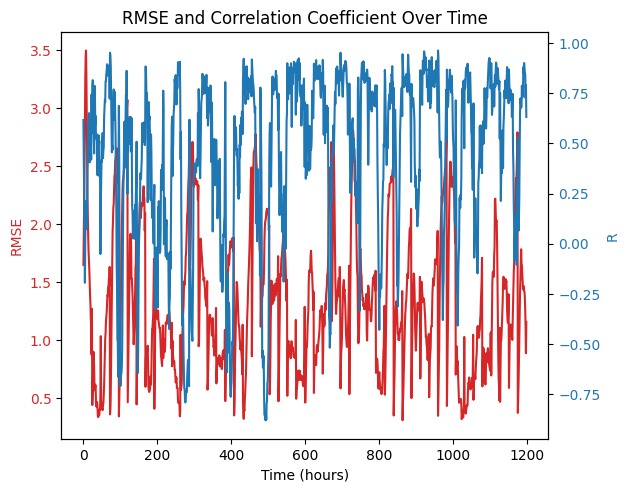

In [33]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat

def plot_results(filename):
    # 加载数据
    data = loadmat(filename)
    prediction = data["prediction"]
    truth = data["truth"][:prediction.shape[0]]  # 只取前prediction.shape[0]个数据
    noisy_obs = data["noisy_obs"]
    
    # 计算均方根误差(RMSE)
    rmse = np.sqrt(np.mean((prediction - truth)**2, axis=(1, 2, 3)))

    # 计算相关系数R
    reshaped_prediction = prediction.reshape(prediction.shape[0], -1)
    reshaped_truth = truth.reshape(truth.shape[0], -1)
    r_values = np.array([np.corrcoef(reshaped_prediction[i], reshaped_truth[i])[0, 1] for i in range(reshaped_prediction.shape[0])])
    
    # 绘图
    time = np.arange(len(rmse))
    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('RMSE', color=color)
    ax1.plot(time, rmse, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
    color = 'tab:blue'
    ax2.set_ylabel('R', color=color)  # we already handled the x-label with ax
    ax2.plot(time, r_values, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    plt.title('RMSE and Correlation Coefficient Over Time')
    plt.show()

filename = "era5_DA_every24HR_lead1200_everytime_noise_" + str(1) + ".mat"  # 这里我用1作为noise的例子
plot_results(filename)


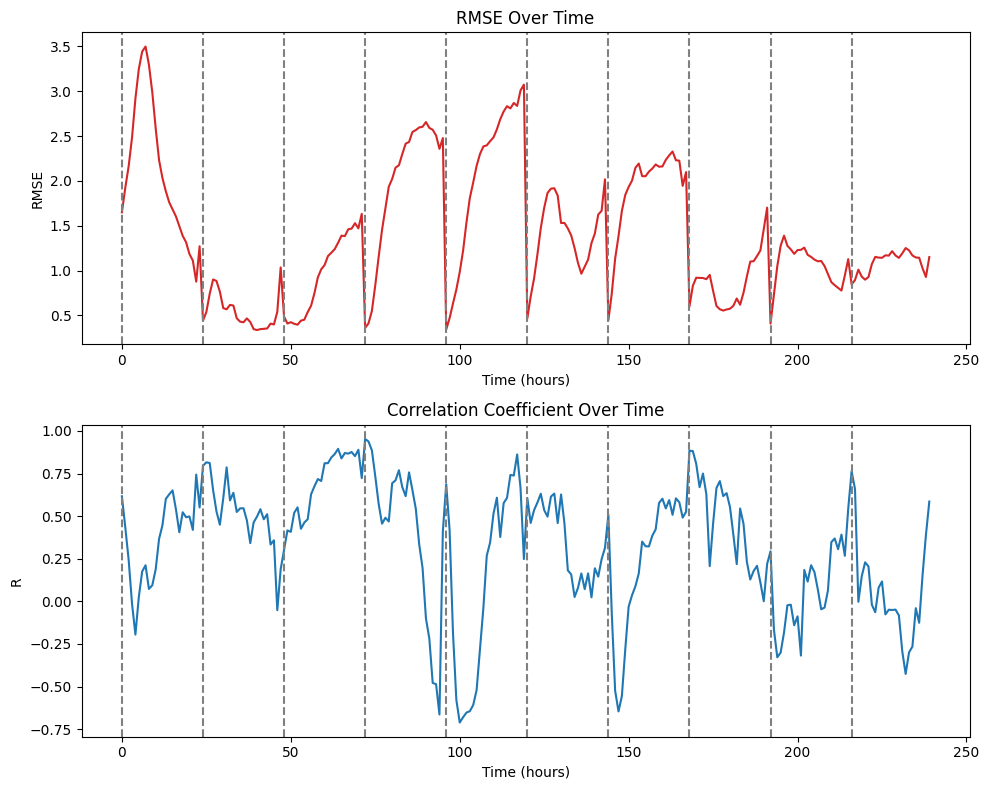

In [34]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

def plot_results(filename):
    # 加载数据
    data = loadmat(filename)
    prediction = data["prediction"][:240]
    truth = data["truth"][:240]
    noisy_obs = data["noisy_obs"][:240]
    
    # 计算均方根误差(RMSE)
    rmse = np.sqrt(np.mean((prediction - truth)**2, axis=(1, 2, 3)))

    # 计算相关系数R
    reshaped_prediction = prediction.reshape(prediction.shape[0], -1)
    reshaped_truth = truth.reshape(truth.shape[0], -1)
    r_values = np.array([np.corrcoef(reshaped_prediction[i], reshaped_truth[i])[0, 1] for i in range(reshaped_prediction.shape[0])])
    
    # 绘制RMSE子图
    time = np.arange(240)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # RMSE
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('RMSE')
    ax1.plot(time, rmse, color='tab:red')
    for x in range(0, 240, 24):  # 每24小时绘制一条虚线
        ax1.axvline(x, color='gray', linestyle='--')
    ax1.set_title('RMSE Over Time')

    # R value
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('R')
    ax2.plot(time, r_values, color='tab:blue')
    for x in range(0, 240, 24):  # 每24小时绘制一条虚线
        ax2.axvline(x, color='gray', linestyle='--')
    ax2.set_title('Correlation Coefficient Over Time')
    
    fig.tight_layout()
    plt.show()

filename = "era5_DA_every24HR_lead1200_everytime_noise_" + str(1)
plot_results(filename)


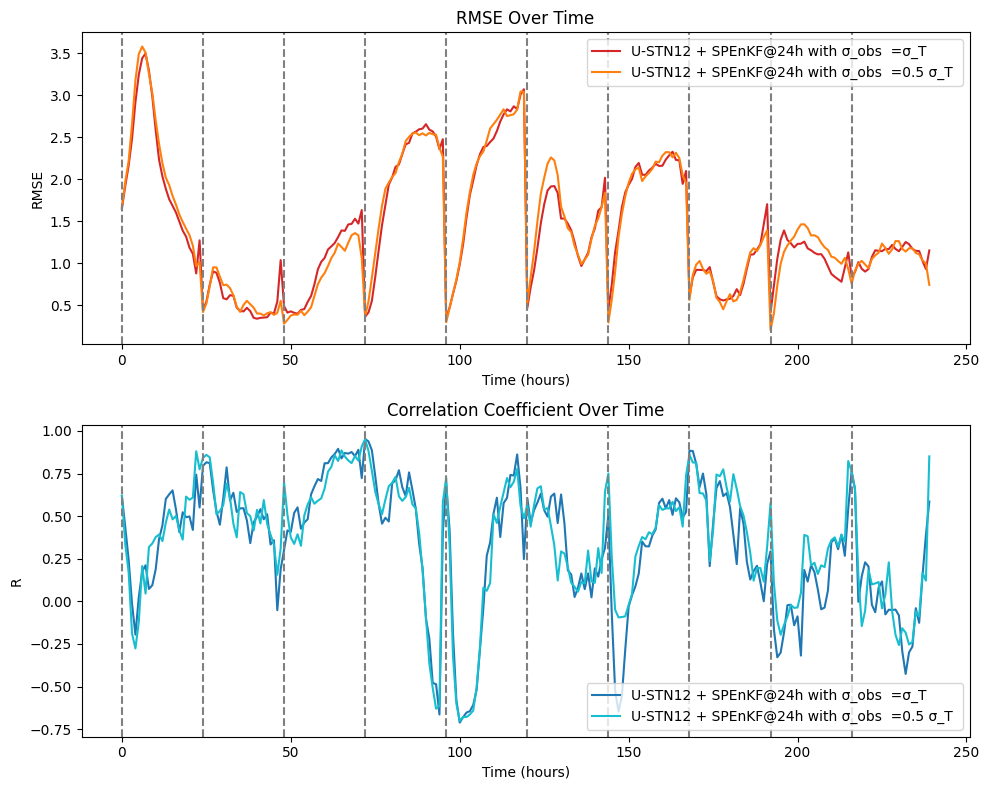

In [39]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat

def calculate_metrics(filename):
    # Load the data
    data = loadmat(filename)
    prediction = data["prediction"][:240]
    truth = data["truth"][:240]

    # Calculate Root Mean Square Error (RMSE)
    rmse = np.sqrt(np.mean((prediction - truth)**2, axis=(1, 2, 3)))

    # Calculate the correlation coefficient R
    reshaped_prediction = prediction.reshape(prediction.shape[0], -1)
    reshaped_truth = truth.reshape(truth.shape[0], -1)
    r_values = np.array([np.corrcoef(reshaped_prediction[i], reshaped_truth[i])[0, 1] for i in range(reshaped_prediction.shape[0])])

    return rmse, r_values

def plot_combined_results(filename1, label1, filename2, label2):
    rmse1, r_values1 = calculate_metrics(filename1)
    rmse2, r_values2 = calculate_metrics(filename2)

    # Plotting
    time = np.arange(240)
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

    # RMSE
    ax1.set_xlabel('Time (hours)')
    ax1.set_ylabel('RMSE')
    ax1.plot(time, rmse1, color='tab:red', label=label1)
    ax1.plot(time, rmse2, color='tab:orange', label=label2)
    for x in range(0, 240, 24):  # Add dashed lines every 24 hours
        ax1.axvline(x, color='gray', linestyle='--')
    ax1.legend()
    ax1.set_title('RMSE Over Time')

    # R value
    ax2.set_xlabel('Time (hours)')
    ax2.set_ylabel('R')
    ax2.plot(time, r_values1, color='tab:blue', label=label1)
    ax2.plot(time, r_values2, color='tab:cyan', label=label2)
    for x in range(0, 240, 24):  # Add dashed lines every 24 hours
        ax2.axvline(x, color='gray', linestyle='--')
    ax2.legend()
    ax2.set_title('Correlation Coefficient Over Time')

    fig.tight_layout()
    plt.show()

filename1 = "era5_DA_every24HR_lead1200_everytime_noise_" + str(1) + ".mat"
filename2 = "era5_DA_every24HR_lead1200_everytime_noise_" + str(0.5) + ".mat"

plot_combined_results(filename1, 'U-STN12 + SPEnKF@24h with σ_obs = σ_T', filename2, 'U-STN12 + SPEnKF@24h with σ_obs = 0.5 σ_T')


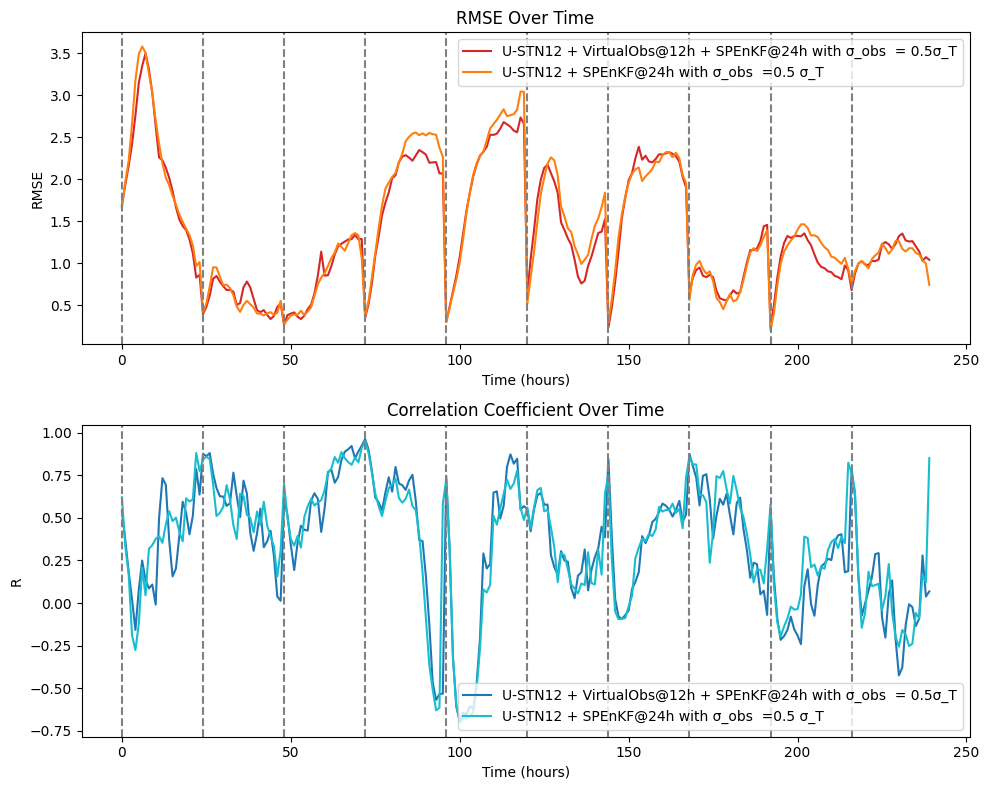

In [43]:
filename1 = "Version2_DA_every24HR_lead1200_everytime_noise_0.5_2DA" + ".mat"
filename2 = "era5_DA_every24HR_lead1200_everytime_noise_" + str(0.5) + ".mat"

plot_combined_results(filename1, 'U-STN12 + VirtualObs@12h + SPEnKF@24h with σ_obs  = 0.5σ_T', filename2, 'U-STN12 + SPEnKF@24h with σ_obs  =0.5 σ_T')


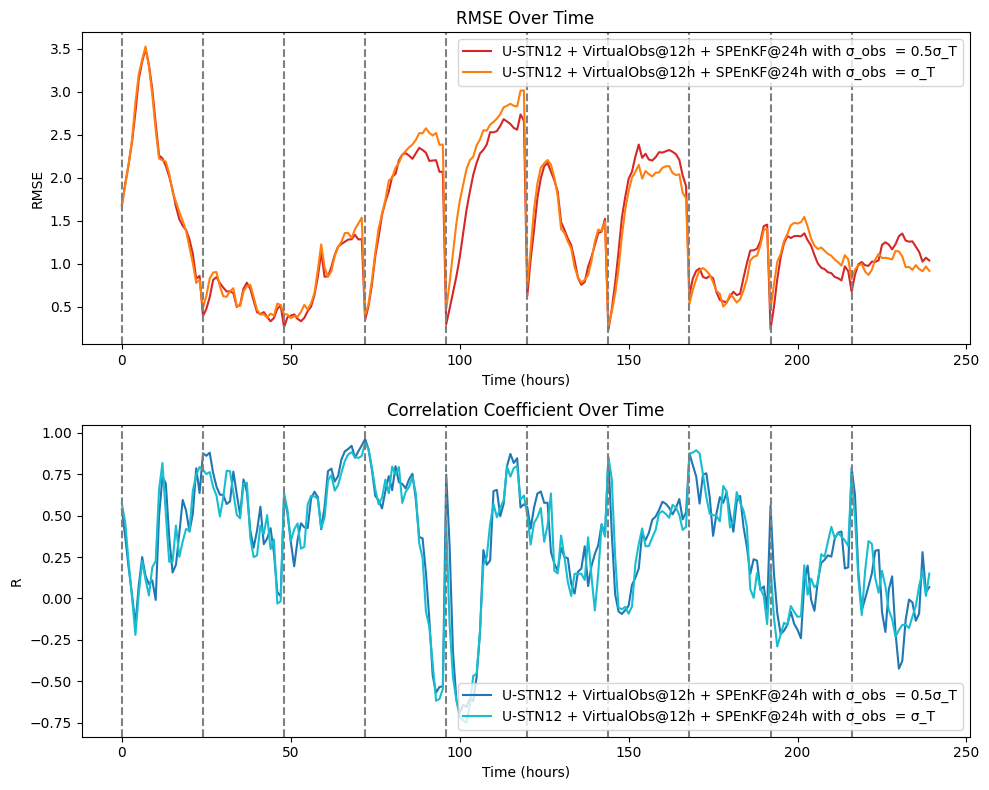

In [44]:
filename1 = "Version2_DA_every24HR_lead1200_everytime_noise_0.5_2DA" + ".mat"
filename2 = "Version2_DA_every24HR_lead1200_everytime_noise_1_2DA"+ ".mat"

plot_combined_results(filename1, 'U-STN12 + VirtualObs@12h + SPEnKF@24h with σ_obs  = 0.5σ_T', filename2, 'U-STN12 + VirtualObs@12h + SPEnKF@24h with σ_obs  = σ_T')


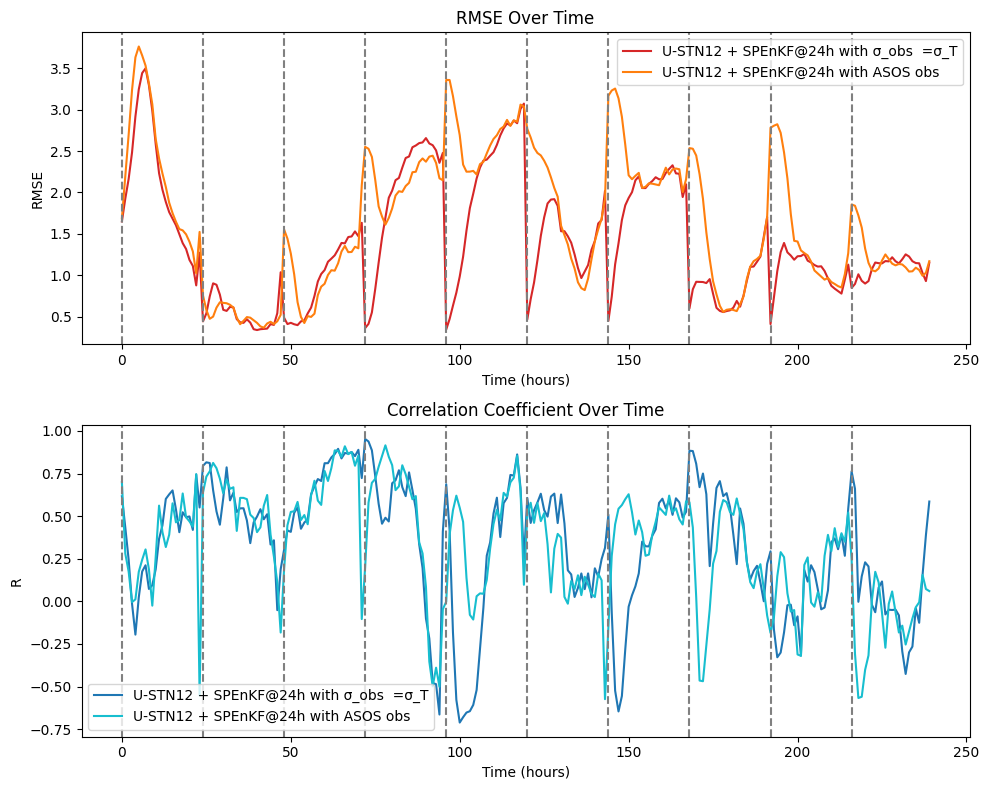

In [45]:
filename1 = "era5_DA_every24HR_lead1200_everytime_noise_" + str(1) + ".mat"
filename2 = "DA_every24HR_lead1200_everytime_noise_asos"  + ".mat"

plot_combined_results(filename1, 'U-STN12 + SPEnKF@24h with σ_obs  =σ_T', filename2, 'U-STN12 + SPEnKF@24h with ASOS obs ')


In [ ]:
filename1 = "era5_DA_every24HR_lead1200_everytime_noise_" + str(1) + ".mat"
filename2 = "DA_every24HR_lead1200_everytime_noise_asos"  + ".mat"

plot_combined_results(filename1, 'Noise = 1 truth', filename2, 'Noise = 1 asos')

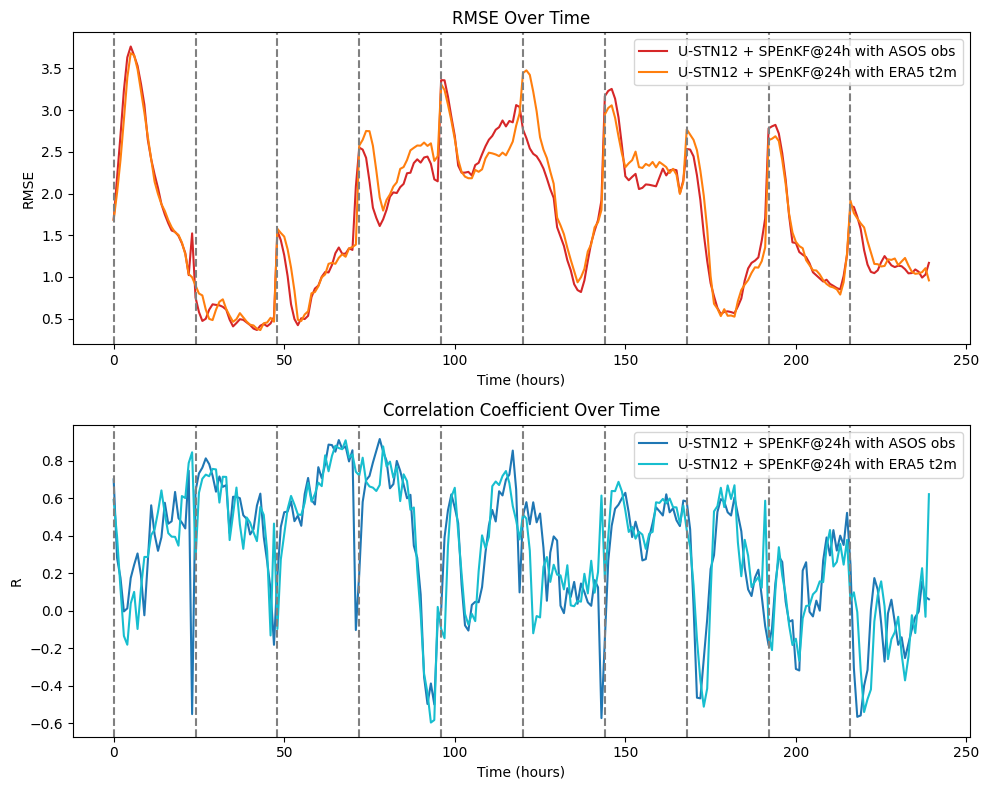

In [46]:
filename1 = "DA_every24HR_lead1200_everytime_noise_asos" + ".mat"
filename2 = "DA_every24HR_lead1200_everytime_noise_t2m"  + ".mat"

plot_combined_results(filename1, 'U-STN12 + SPEnKF@24h with ASOS obs', filename2, 'U-STN12 + SPEnKF@24h with ERA5 t2m')

### 2 truth + noise = 0.5

In [13]:
####### True data (noise free) for twin DA experiments ##########
## here can be modified 

F=nc.Dataset(fileList_test[1])
Z=np.asarray(F['t'])
TRUTH=Z

### Meshgrid for plotting ###
[qx,qy]=np.meshgrid(lon,lat)

In [14]:
##### Add noise to the truth to mimic observations####
#### Value 1 is 1*\sigma_Z. See more in paper #####
Z_rs = np.reshape(Z,[np.size(Z,0), int(np.size(Z,1)*np.size(Z,2))])
TRUTH = Z_rs
Z_rs = (Z_rs-M)/sdev
TRUTH = (TRUTH-M)/sdev
noise=0.5 # modify here

In [15]:
for k in range(1,np.size(Z_rs,0)):
    Z_rs[k-1,:]=Z_rs[k-1,:]+np.random.normal(0, noise, 2048)
print('length of initial condition',len(Z_rs[0,:]))

length of initial condition 2048


In [54]:
###### Start Data Assimilation Process #########################################

time = 1300
n=int(32*64)
P=np.eye(n,n)

Q=0.03*np.eye(n,n)

R=0.0001

u_ensemble=np.zeros([32*64,2*32*64])

pred=np.zeros([time,32,64,1])


dt=24
count=0

In [ ]:
for t in tqdm(range(0, time, dt)):
    
    for kk in tqdm(range(0,dt-1)):
        if (kk==0):   
          u=Z_rs[t+kk,:].reshape([1, 32, 64, 1 ])
          u=model.predict(u.reshape([1,32,64,1]))
        else :
      
          u=model.predict(u)
        
        pred[count,:,:,0]=np.reshape(u,[32,64])
        count=count+1
    x=u   
    x, P = ENKF(x, 2048, P, Q, R, Z_rs[t+dt,:], model,u_ensemble)
   
    print('output shape of ENKF', np.shape(x))
    
    pred[count, :, :, 0] = np.reshape(x, [32, 64])
    count = count + 1

100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.67it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▉                                                                    | 565/4096 [00:14<01:24, 41.89it/s]


 28%|██████████████████████▏                                                       | 1163/4096 [00:30<01:18, 37.15it/s]


 42%|████████████████████████████████▉                                             | 1727/4096 [00:45<01:07, 35.02it/s]


 56%|███████████████████████████████████████████▌                                  | 2288/4096 [01:01<00:51, 35.14it/s]


 69%|█████████████████████████████████████████████████████▉                        | 2830/4096 [01:16<00:35, 35.22it/s]


 83%|████████████████████████████████████████████████████████████████▉             | 3409/4096 [01:32<00:20, 33.99it/s]


 96%|███████████████████████████████████████████████████████████████████████████▎  | 3952/4096 [01:48<00:03, 36.44it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:52<00:00, 36.51it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  2%|█▍                                                                              | 1/57 [02:41<2:30:36, 161.37s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.96it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▍                                                                    | 540/4096 [00:15<01:39, 35.88it/s]


 27%|█████████████████████                                                         | 1106/4096 [00:30<01:20, 37.06it/s]


 40%|███████████████████████████████▌                                              | 1656/4096 [00:46<01:06, 36.83it/s]


 54%|██████████████████████████████████████████                                    | 2212/4096 [01:01<00:51, 36.69it/s]


 68%|████████████████████████████████████████████████████▋                         | 2767/4096 [01:16<00:33, 40.20it/s]


 81%|███████████████████████████████████████████████████████████████▍              | 3332/4096 [01:32<00:22, 33.26it/s]


 95%|██████████████████████████████████████████████████████████████████████████    | 3886/4096 [01:47<00:05, 37.10it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.15it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  4%|██▊                                                                             | 2/57 [05:46<2:40:40, 175.29s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 46.84it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▎                                                                    | 535/4096 [00:15<01:44, 34.01it/s]


 26%|████████████████████▍                                                         | 1074/4096 [00:30<01:25, 35.24it/s]


 40%|███████████████████████████████▏                                              | 1636/4096 [00:46<00:59, 41.55it/s]


 53%|█████████████████████████████████████████▍                                    | 2179/4096 [01:01<00:54, 35.04it/s]


 66%|███████████████████████████████████████████████████▋                          | 2716/4096 [01:17<00:39, 34.55it/s]


 79%|█████████████████████████████████████████████████████████████▉                | 3252/4096 [01:33<00:24, 33.84it/s]


 93%|████████████████████████████████████████████████████████████████████████▍     | 3805/4096 [01:48<00:08, 33.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:57<00:00, 34.99it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  5%|████▏                                                                           | 3/57 [08:40<2:37:08, 174.61s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.11it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▉                                                                    | 564/4096 [00:15<01:01, 57.03it/s]


 29%|███████████████████████                                                       | 1208/4096 [00:30<01:22, 34.91it/s]


 43%|█████████████████████████████████▌                                            | 1760/4096 [00:45<01:02, 37.08it/s]


 57%|████████████████████████████████████████████▎                                 | 2330/4096 [01:01<00:49, 35.61it/s]


 71%|███████████████████████████████████████████████████████                       | 2890/4096 [01:16<00:33, 35.65it/s]


 84%|█████████████████████████████████████████████████████████████████▌            | 3440/4096 [01:31<00:18, 35.51it/s]


 97%|████████████████████████████████████████████████████████████████████████████  | 3992/4096 [01:47<00:02, 39.01it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:50<00:00, 37.21it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  7%|█████▌                                                                          | 4/57 [11:09<2:25:19, 164.52s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.11it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 15%|███████████▌                                                                   | 601/4096 [00:15<01:28, 39.32it/s]


 28%|██████████████████████▏                                                       | 1163/4096 [00:30<01:22, 35.77it/s]


 42%|████████████████████████████████▋                                             | 1718/4096 [00:45<01:04, 36.62it/s]


 55%|███████████████████████████████████████████▏                                  | 2270/4096 [01:01<00:54, 33.77it/s]


 69%|█████████████████████████████████████████████████████▋                        | 2816/4096 [01:16<00:37, 34.48it/s]


 82%|████████████████████████████████████████████████████████████████▏             | 3371/4096 [01:32<00:20, 34.91it/s]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3908/4096 [01:47<00:05, 35.83it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.22it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  9%|███████                                                                         | 5/57 [14:01<2:24:53, 167.19s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.97it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▋                                                                    | 554/4096 [00:15<01:42, 34.63it/s]


 27%|████████████████████▉                                                         | 1100/4096 [00:30<01:30, 32.95it/s]


 40%|███████████████████████████████▍                                              | 1649/4096 [00:46<01:10, 34.95it/s]


 54%|██████████████████████████████████████████                                    | 2207/4096 [01:01<00:49, 38.51it/s]


 68%|████████████████████████████████████████████████████▉                         | 2781/4096 [01:17<00:32, 40.18it/s]


 82%|███████████████████████████████████████████████████████████████▊              | 3353/4096 [01:32<00:20, 35.65it/s]


 95%|██████████████████████████████████████████████████████████████████████████▍   | 3910/4096 [01:48<00:05, 35.66it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.14it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 11%|████████▍                                                                       | 6/57 [17:02<2:26:09, 171.95s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 55.35it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▍                                                                    | 543/4096 [00:15<01:22, 43.27it/s]


 27%|████████████████████▊                                                         | 1096/4096 [00:30<01:23, 35.98it/s]


 40%|███████████████████████████████▎                                              | 1645/4096 [00:46<01:06, 36.84it/s]


 54%|█████████████████████████████████████████▉                                    | 2203/4096 [01:01<00:52, 36.18it/s]


 67%|████████████████████████████████████████████████████▎                         | 2750/4096 [01:16<00:36, 37.00it/s]


 81%|███████████████████████████████████████████████████████████████▎              | 3323/4096 [01:32<00:21, 36.49it/s]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3877/4096 [01:47<00:05, 38.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.13it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 12%|█████████▊                                                                      | 7/57 [19:37<2:18:48, 166.58s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 39.61it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|███████████▏                                                                   | 579/4096 [00:15<01:29, 39.31it/s]


 28%|██████████████████████                                                        | 1157/4096 [00:30<01:19, 37.02it/s]


 42%|████████████████████████████████▌                                             | 1709/4096 [00:45<01:11, 33.35it/s]


 56%|███████████████████████████████████████████▌                                  | 2285/4096 [01:01<00:41, 43.14it/s]


 70%|██████████████████████████████████████████████████████▉                       | 2887/4096 [01:16<00:33, 36.15it/s]


 84%|█████████████████████████████████████████████████████████████████▋            | 3449/4096 [01:32<00:18, 34.07it/s]


 98%|████████████████████████████████████████████████████████████████████████████▏ | 3998/4096 [01:47<00:02, 35.49it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:50<00:00, 37.20it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 14%|███████████▏                                                                    | 8/57 [22:26<2:16:40, 167.36s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.90it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▊                                                                    | 563/4096 [00:15<01:45, 33.62it/s]


 27%|████████████████████▉                                                         | 1101/4096 [00:31<01:13, 40.49it/s]


 40%|███████████████████████████████▍                                              | 1652/4096 [00:46<01:06, 36.74it/s]


 54%|██████████████████████████████████████████                                    | 2207/4096 [01:01<00:45, 41.77it/s]


 67%|████████████████████████████████████████████████████▌                         | 2759/4096 [01:17<00:39, 33.88it/s]


 81%|███████████████████████████████████████████████████████████████▎              | 3326/4096 [01:32<00:19, 40.49it/s]


 95%|█████████████████████████████████████████████████████████████████████████▊    | 3878/4096 [01:48<00:06, 34.90it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:54<00:00, 35.92it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 16%|████████████▋                                                                   | 9/57 [25:34<2:18:51, 173.57s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.17it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▍                                                                    | 539/4096 [00:15<01:33, 37.90it/s]


 26%|████████████████████▍                                                         | 1076/4096 [00:30<01:29, 33.85it/s]


 40%|██████████████████████████████▉                                               | 1625/4096 [00:46<01:11, 34.59it/s]


 53%|█████████████████████████████████████████▎                                    | 2171/4096 [01:01<00:54, 35.14it/s]


 66%|███████████████████████████████████████████████████▋                          | 2712/4096 [01:17<00:38, 35.77it/s]


 80%|██████████████████████████████████████████████████████████████▏               | 3267/4096 [01:32<00:21, 38.70it/s]


 93%|████████████████████████████████████████████████████████████████████████▊     | 3821/4096 [01:48<00:07, 38.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:55<00:00, 35.41it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 18%|█████████████▊                                                                 | 10/57 [28:32<2:17:03, 174.97s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.79it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▌                                                                    | 550/4096 [00:15<01:38, 36.15it/s]


 27%|█████████████████████▎                                                        | 1119/4096 [00:30<01:21, 36.61it/s]


 41%|████████████████████████████████                                              | 1685/4096 [00:46<01:03, 38.05it/s]


 55%|██████████████████████████████████████████▉                                   | 2252/4096 [01:01<00:40, 45.22it/s]


 69%|█████████████████████████████████████████████████████▊                        | 2825/4096 [01:16<00:34, 36.86it/s]


 83%|████████████████████████████████████████████████████████████████▌             | 3393/4096 [01:31<00:17, 40.50it/s]


 97%|███████████████████████████████████████████████████████████████████████████▌  | 3966/4096 [01:47<00:03, 33.46it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:51<00:00, 36.87it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 19%|███████████████▏                                                               | 11/57 [30:58<2:07:29, 166.30s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.82it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 15%|███████████▋                                                                   | 608/4096 [00:15<01:26, 40.31it/s]


 29%|██████████████████████▌                                                       | 1187/4096 [00:31<01:14, 38.86it/s]


 42%|█████████████████████████████████                                             | 1737/4096 [00:46<00:59, 39.69it/s]


 56%|███████████████████████████████████████████▌                                  | 2285/4096 [01:01<00:50, 35.54it/s]


 69%|█████████████████████████████████████████████████████▉                        | 2830/4096 [01:16<00:30, 41.62it/s]


 83%|████████████████████████████████████████████████████████████████▍             | 3387/4096 [01:32<00:20, 34.58it/s]


 97%|███████████████████████████████████████████████████████████████████████████▎  | 3958/4096 [01:47<00:03, 38.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:51<00:00, 36.76it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 21%|████████████████▋                                                              | 12/57 [33:57<2:07:35, 170.11s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.68it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▌                                                                    | 545/4096 [00:15<01:42, 34.51it/s]


 28%|█████████████████████▌                                                        | 1131/4096 [00:30<01:08, 43.45it/s]


 43%|█████████████████████████████████▎                                            | 1748/4096 [00:46<01:06, 35.54it/s]


 56%|███████████████████████████████████████████▊                                  | 2301/4096 [01:01<00:45, 39.56it/s]


 70%|██████████████████████████████████████████████████████▍                       | 2856/4096 [01:16<00:35, 35.31it/s]


 84%|█████████████████████████████████████████████████████████████████▎            | 3428/4096 [01:32<00:18, 36.79it/s]


 97%|████████████████████████████████████████████████████████████████████████████  | 3993/4096 [01:47<00:02, 35.96it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:49<00:00, 37.24it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 23%|██████████████████                                                             | 13/57 [36:53<2:06:07, 171.98s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.47it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▊                                                                    | 558/4096 [00:15<01:32, 38.41it/s]


 27%|█████████████████████▎                                                        | 1116/4096 [00:30<01:25, 34.69it/s]


 41%|████████████████████████████████                                              | 1685/4096 [00:45<01:07, 35.59it/s]


 55%|██████████████████████████████████████████▋                                   | 2241/4096 [01:01<00:49, 37.41it/s]


 68%|█████████████████████████████████████████████████████▏                        | 2791/4096 [01:16<00:34, 37.73it/s]


 81%|███████████████████████████████████████████████████████████████▌              | 3335/4096 [01:32<00:20, 37.09it/s]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3883/4096 [01:47<00:05, 39.13it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.11it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 25%|███████████████████▍                                                           | 14/57 [39:30<1:59:54, 167.32s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.91it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▌                                                                    | 548/4096 [00:15<01:36, 36.72it/s]


 27%|█████████████████████▎                                                        | 1116/4096 [00:30<01:23, 35.54it/s]


 41%|███████████████████████████████▊                                              | 1670/4096 [00:46<01:08, 35.47it/s]


 54%|██████████████████████████████████████████▎                                   | 2223/4096 [01:01<00:51, 36.55it/s]


 68%|████████████████████████████████████████████████████▉                         | 2779/4096 [01:16<00:34, 37.98it/s]


 81%|███████████████████████████████████████████████████████████████▎              | 3326/4096 [01:31<00:22, 34.76it/s]


 94%|█████████████████████████████████████████████████████████████████████████▋    | 3869/4096 [01:47<00:06, 36.43it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.08it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 26%|████████████████████▊                                                          | 15/57 [42:15<1:56:41, 166.70s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 38.12it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▊                                                                    | 558/4096 [00:15<01:39, 35.72it/s]


 28%|█████████████████████▍                                                        | 1129/4096 [00:30<01:19, 37.23it/s]


 41%|███████████████████████████████▉                                              | 1676/4096 [00:45<01:05, 36.96it/s]


 54%|██████████████████████████████████████████▏                                   | 2218/4096 [01:00<00:49, 37.91it/s]


 68%|████████████████████████████████████████████████████▉                         | 2781/4096 [01:16<00:36, 35.96it/s]


 82%|███████████████████████████████████████████████████████████████▌              | 3339/4096 [01:31<00:21, 34.92it/s]


 95%|█████████████████████████████████████████████████████████████████████████▉    | 3885/4096 [01:47<00:06, 35.08it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.19it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 28%|██████████████████████▏                                                        | 16/57 [45:16<1:56:49, 170.97s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 37.15it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|██████████▋                                                                    | 555/4096 [00:15<01:40, 35.16it/s]


 27%|█████████████████████▏                                                        | 1110/4096 [00:30<01:16, 39.18it/s]


 41%|███████████████████████████████▋                                              | 1661/4096 [00:46<01:02, 39.03it/s]


 54%|██████████████████████████████████████████                                    | 2207/4096 [01:01<00:55, 34.15it/s]


 67%|████████████████████████████████████████████████████▎                         | 2745/4096 [01:17<00:39, 34.05it/s]


 81%|██████████████████████████████████████████████████████████████▊               | 3298/4096 [01:32<00:22, 36.15it/s]


 94%|█████████████████████████████████████████████████████████████████████████▏    | 3843/4096 [01:47<00:07, 35.88it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:55<00:00, 35.61it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 30%|███████████████████████▌                                                       | 17/57 [48:03<1:53:10, 169.75s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.51it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▎                                                                    | 535/4096 [00:14<01:30, 39.26it/s]


 27%|████████████████████▊                                                         | 1091/4096 [00:30<01:27, 34.53it/s]


 40%|███████████████████████████████▎                                              | 1642/4096 [00:45<01:09, 35.15it/s]


 54%|██████████████████████████████████████████▏                                   | 2215/4096 [01:00<00:48, 39.17it/s]


 69%|█████████████████████████████████████████████████████▍                        | 2808/4096 [01:16<00:33, 38.61it/s]


 83%|████████████████████████████████████████████████████████████████▉             | 3408/4096 [01:31<00:17, 38.61it/s]


 97%|███████████████████████████████████████████████████████████████████████████▊  | 3981/4096 [01:47<00:02, 41.71it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:49<00:00, 37.31it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 32%|████████████████████████▉                                                      | 18/57 [50:41<1:47:57, 166.09s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 35.97it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|███████████▎                                                                   | 584/4096 [00:15<01:33, 37.39it/s]


 30%|███████████████████████▋                                                      | 1242/4096 [00:30<01:06, 43.06it/s]


 45%|███████████████████████████████████▏                                          | 1845/4096 [00:46<00:59, 37.69it/s]


 59%|█████████████████████████████████████████████▋                                | 2400/4096 [01:01<00:40, 41.73it/s]


 73%|████████████████████████████████████████████████████████▋                     | 2975/4096 [01:17<00:30, 36.26it/s]


 86%|██████████████████████████████████████████████████████████████████▉           | 3517/4096 [01:32<00:17, 33.70it/s]


 99%|█████████████████████████████████████████████████████████████████████████████▍| 4068/4096 [01:48<00:00, 36.61it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:49<00:00, 37.56it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 33%|██████████████████████████▎                                                    | 19/57 [53:41<1:47:56, 170.43s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 60.95it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 13%|██████████▌                                                                    | 547/4096 [00:15<01:40, 35.18it/s]


 27%|█████████████████████                                                         | 1103/4096 [00:30<01:19, 37.45it/s]


 40%|███████████████████████████████▍                                              | 1653/4096 [00:45<01:10, 34.84it/s]


 54%|█████████████████████████████████████████▉                                    | 2201/4096 [01:01<00:51, 36.88it/s]


 67%|████████████████████████████████████████████████████▏                         | 2741/4096 [01:16<00:38, 35.23it/s]


 81%|███████████████████████████████████████████████████████████████               | 3309/4096 [01:31<00:21, 36.69it/s]


 94%|█████████████████████████████████████████████████████████████████████████▌    | 3863/4096 [01:46<00:06, 35.15it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:53<00:00, 36.18it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 35%|███████████████████████████▋                                                   | 20/57 [56:28<1:44:26, 169.35s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 53.10it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 15%|███████████▋                                                                   | 606/4096 [00:15<01:25, 41.02it/s]


 30%|███████████████████████▍                                                      | 1228/4096 [00:31<01:14, 38.52it/s]


 45%|███████████████████████████████████                                           | 1842/4096 [00:46<00:59, 37.67it/s]


 59%|██████████████████████████████████████████████▎                               | 2434/4096 [01:01<00:44, 37.62it/s]


 74%|█████████████████████████████████████████████████████████▉                    | 3045/4096 [01:17<00:27, 37.61it/s]


 89%|█████████████████████████████████████████████████████████████████████▊        | 3664/4096 [01:33<00:11, 39.24it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:44<00:00, 39.26it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 37%|█████████████████████████████                                                  | 21/57 [58:53<1:37:15, 162.11s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 40.63it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 15%|███████████▍                                                                   | 596/4096 [00:15<01:28, 39.73it/s]


 29%|██████████████████████▋                                                       | 1194/4096 [00:30<01:14, 39.16it/s]


 44%|██████████████████████████████████                                            | 1789/4096 [00:46<00:59, 39.01it/s]


 58%|█████████████████████████████████████████████▍                                | 2389/4096 [01:01<00:41, 41.37it/s]


 73%|████████████████████████████████████████████████████████▉                     | 2993/4096 [01:16<00:28, 38.83it/s]


 88%|████████████████████████████████████████████████████████████████████▍         | 3591/4096 [01:32<00:13, 38.58it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:45<00:00, 38.94it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 39%|█████████████████████████████▋                                               | 22/57 [1:01:49<1:36:57, 166.22s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 43.19it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 16%|████████████▉                                                                  | 674/4096 [00:15<01:25, 39.89it/s]


 32%|████████████████████████▉                                                     | 1308/4096 [00:31<01:03, 44.22it/s]


 47%|████████████████████████████████████▉                                         | 1939/4096 [00:46<00:55, 38.86it/s]


 61%|███████████████████████████████████████████████▊                              | 2508/4096 [01:02<00:40, 39.24it/s]


 77%|███████████████████████████████████████████████████████████▋                  | 3136/4096 [01:17<00:23, 40.46it/s]


 91%|███████████████████████████████████████████████████████████████████████▎      | 3742/4096 [01:33<00:09, 39.20it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:41<00:00, 40.16it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 40%|███████████████████████████████                                              | 23/57 [1:04:27<1:32:44, 163.65s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 45.92it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|███████████▍                                                                   | 591/4096 [00:15<01:29, 39.04it/s]


 29%|██████████████████████▉                                                       | 1206/4096 [00:30<01:14, 38.68it/s]


 44%|██████████████████████████████████▌                                           | 1818/4096 [00:46<01:00, 37.46it/s]


 59%|██████████████████████████████████████████████▍                               | 2437/4096 [01:01<00:36, 44.87it/s]


 74%|█████████████████████████████████████████████████████████▉                    | 3042/4096 [01:17<00:28, 37.57it/s]


 89%|█████████████████████████████████████████████████████████████████████▎        | 3640/4096 [01:32<00:11, 39.79it/s]


100%|██████████████████████████████████████████████████████████████████████████████| 4096/4096 [01:44<00:00, 39.14it/s]


x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 42%|████████████████████████████████▍                                            | 24/57 [1:06:53<1:27:11, 158.52s/it]

x

output shape of ENKF (2048, 1)



100%|██████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 41.10it/s]


obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 14%|███████████▍                                                                   | 590/4096 [00:15<01:25, 40.90it/s]


 31%|████████████████████████▎                                                     | 1277/4096 [00:30<01:02, 45.30it/s]


 41%|███████████████████████████████▋                                              | 1665/4096 [00:39<00:53, 45.16it/s]

In [53]:
sio.savemat(
    "DA_every24HR_lead1200_everytime_noise_" + str(noise) + ".mat",
    dict(
        [
            ("prediction", pred),
            ("truth", np.reshape(TRUTH, [np.size(Z_rs, 0), 32, 64, 1])),
            ("noisy_obs", np.reshape(Z_rs, [np.size(Z_rs, 0), 32, 64, 1])),
        ]
    ),
)

print("Done writing file")

Done writing file


### 3 virtual + noise =1

In [77]:
####### True data (noise free) for twin DA experiments ##########
## here can be modified 

F=nc.Dataset(fileList_test[1])
Z=np.asarray(F['t'])
TRUTH=Z

### Meshgrid for plotting ###
[qx,qy]=np.meshgrid(lon,lat)

In [26]:
##### Add noise to the truth to mimic observations####
#### Value 1 is 1*\sigma_Z. See more in paper #####
Z_rs = np.reshape(Z,[np.size(Z,0), int(np.size(Z,1)*np.size(Z,2))])
TRUTH = Z_rs
Z_rs = (Z_rs-M)/sdev
TRUTH = (TRUTH-M)/sdev
noise=1 # modify here

In [27]:
for k in range(1,np.size(Z_rs,0)):
    Z_rs[k-1,:]=Z_rs[k-1,:]+np.random.normal(0, noise, 2048)
print('length of initial condition',len(Z_rs[0,:]))

length of initial condition 2048


In [28]:
###### Start Data Assimilation Process #########################################
model_vir=stn()
model_vir.load_weights(best_weight)
time = 1200

D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if __name__ == "__main__":
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if sys.path[0]

In [29]:
virtual_obs=np.zeros([100,32,64,1])
dt=24
dt_virtual=12

count=0
for t in range(0, time, dt_virtual):

    if (t==0):
        u = model_vir.predict(TRUTH[0,:].reshape([1,32,64,1]))
         
    
    
    
    else:

        u=model_vir.predict(u.reshape([1, 32, 64, 1]))

    virtual_obs[count,:,:,0]=np.reshape(u,[32,64])
    count=count+1

vir_obs_rs=np.reshape(virtual_obs,[np.size(virtual_obs,0), np.size(virtual_obs,1)*np.size(virtual_obs,2)]) 

In [30]:
n=int(32*64)
P=np.eye(n,n)

Q=0.03*np.eye(n,n)

R=0.0001

u_ensemble=np.zeros([32*64,2*32*64])

pred=np.zeros([time,32,64,1])

In [31]:
dt=24
dt_virtual=12
count=0
for t in tqdm(range(0, time, dt)):
        
    for kk in range(0,dt):
        if (kk==0):   
          u=Z_rs[t+kk,:].reshape([1, 32, 64, 1 ])
          u=model.predict(u.reshape([1,32,64,1]))
         
        
        elif (kk == dt_virtual-1):

            y = u
            y, P =  ENKF(y, 2048, P, Q, R, vir_obs_rs[int((t+dt_virtual)/dt_virtual),:], model,u_ensemble)
            u = y
        else :
      
            u=model.predict(u.reshape([1, 32, 64, 1]))
        
        pred[count,:,:,0]=np.reshape(u,[32,64])
        count=count+1
    x = u   
    x, P = ENKF(x, 2048, P, Q, R, Z_rs[t+dt,:], model,u_ensemble)
   
    print('output shape of ENKF', np.shape(x))
    

  0%|                                                                                           | 0/50 [00:00<?, ?it/s]

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  2%|█▌                                                                              | 1/50 [11:18<9:14:03, 678.45s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



  4%|███▏                                                                            | 2/50 [22:34<9:01:44, 677.18s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

output shape of ENKF

  6%|████▊                                                                           | 3/50 [33:14<8:36:59, 659.99s/it]

 (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



  8%|██████▍                                                                         | 4/50 [43:32<8:13:29, 643.69s/it]

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x



 10%|████████                                                                        | 5/50 [54:52<8:12:28, 656.63s/it]

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 12%|█████████▎                                                                    | 6/50 [1:05:58<8:03:46, 659.69s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 14%|██████████▉                                                                   | 7/50 [1:10:30<6:21:59, 533.02s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 16%|████████████▍                                                                 | 8/50 [1:14:32<5:08:14, 440.34s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 18%|██████████████                                                                | 9/50 [1:18:33<4:18:23, 378.14s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 20%|███████████████▍                                                             | 10/50 [1:22:35<3:44:07, 336.19s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 22%|████████████████▉                                                            | 11/50 [1:26:38<3:19:50, 307.44s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 24%|██████████████████▍                                                          | 12/50 [1:30:32<3:00:39, 285.25s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 26%|████████████████████                                                         | 13/50 [1:34:23<2:45:43, 268.74s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 28%|█████████████████████▌                                                       | 14/50 [1:38:19<2:35:19, 258.86s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 30%|███████████████████████                                                      | 15/50 [1:42:16<2:27:14, 252.41s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 32%|████████████████████████▋                                                    | 16/50 [1:46:18<2:21:15, 249.27s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 34%|██████████████████████████▏                                                  | 17/50 [1:50:09<2:14:00, 243.66s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 36%|███████████████████████████▋                                                 | 18/50 [1:54:12<2:09:52, 243.50s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 38%|█████████████████████████████▎                                               | 19/50 [1:58:11<2:05:05, 242.13s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 40%|██████████████████████████████▊                                              | 20/50 [2:02:11<2:00:45, 241.52s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 42%|████████████████████████████████▎                                            | 21/50 [2:06:03<1:55:16, 238.51s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 44%|█████████████████████████████████▉                                           | 22/50 [2:10:01<1:51:15, 238.39s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 46%|███████████████████████████████████▍                                         | 23/50 [2:13:53<1:46:28, 236.63s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 48%|████████████████████████████████████▉                                        | 24/50 [2:17:51<1:42:41, 236.99s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 50%|██████████████████████████████████████▌                                      | 25/50 [2:21:39<1:37:34, 234.20s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 52%|████████████████████████████████████████                                     | 26/50 [2:25:33<1:33:37, 234.05s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 54%|█████████████████████████████████████████▌                                   | 27/50 [2:29:18<1:28:40, 231.35s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 56%|███████████████████████████████████████████                                  | 28/50 [2:33:05<1:24:21, 230.05s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 58%|████████████████████████████████████████████▋                                | 29/50 [2:37:02<1:21:16, 232.19s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 60%|██████████████████████████████████████████████▏                              | 30/50 [2:40:59<1:17:56, 233.82s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 62%|███████████████████████████████████████████████▋                             | 31/50 [2:44:56<1:14:18, 234.68s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 64%|█████████████████████████████████████████████████▎                           | 32/50 [2:48:51<1:10:25, 234.76s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 66%|██████████████████████████████████████████████████▊                          | 33/50 [2:52:58<1:07:33, 238.42s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 68%|████████████████████████████████████████████████████▎                        | 34/50 [2:56:52<1:03:14, 237.16s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 70%|███████████████████████████████████████████████████████▎                       | 35/50 [3:00:50<59:22, 237.50s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 72%|████████████████████████████████████████████████████████▉                      | 36/50 [3:04:52<55:42, 238.74s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 74%|██████████████████████████████████████████████████████████▍                    | 37/50 [3:08:51<51:44, 238.78s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 76%|████████████████████████████████████████████████████████████                   | 38/50 [3:12:39<47:07, 235.66s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 78%|█████████████████████████████████████████████████████████████▌                 | 39/50 [3:16:50<44:00, 240.05s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 80%|███████████████████████████████████████████████████████████████▏               | 40/50 [3:20:56<40:17, 241.80s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 82%|████████████████████████████████████████████████████████████████▊              | 41/50 [3:24:56<36:12, 241.40s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 84%|██████████████████████████████████████████████████████████████████▎            | 42/50 [3:28:59<32:14, 241.86s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 86%|███████████████████████████████████████████████████████████████████▉           | 43/50 [3:33:06<28:24, 243.54s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 88%|█████████████████████████████████████████████████████████████████████▌         | 44/50 [3:36:57<23:58, 239.69s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 90%|███████████████████████████████████████████████████████████████████████        | 45/50 [3:40:59<20:02, 240.42s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 92%|████████████████████████████████████████████████████████████████████████▋      | 46/50 [3:44:59<16:01, 240.27s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 94%|██████████████████████████████████████████████████████████████████████████▎    | 47/50 [3:49:40<12:37, 252.51s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 96%|███████████████████████████████████████████████████████████████████████████▊   | 48/50 [3:53:37<08:15, 247.83s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



 98%|█████████████████████████████████████████████████████████████████████████████▍ | 49/50 [3:57:12<03:57, 237.87s/it]

x

output shape of ENKF (2048, 1)
obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P

x

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3

x_prior

shape pf x_prior (2048, 1)
shape pf obs (2048, 1)
cf_ens

P_prior

h_ens

y_prior

shape pf y_prior (2048, 1)
P_y

P_xy

K

P



100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [4:00:59<00:00, 289.19s/it]

x

output shape of ENKF (2048, 1)


In [ ]:
sio.savemat('Version2_DA_every24HR_lead1200_everytime_noise_' + str(noise)+ '_2DA.mat',dict([('prediction',pred),('truth',np.reshape(TRUTH,[np.size(Z_rs,0),32,64,1])),('noisy_obs',np.reshape(Z_rs,[np.size(Z_rs,0),32,64,1]))]))

### 4 viturl + noise =0.5

In [77]:
####### True data (noise free) for twin DA experiments ##########
## here can be modified 

F=nc.Dataset(fileList_test[1])
Z=np.asarray(F['t'])
TRUTH=Z

### Meshgrid for plotting ###
[qx,qy]=np.meshgrid(lon,lat)

In [78]:
##### Add noise to the truth to mimic observations####
#### Value 1 is 1*\sigma_Z. See more in paper #####
Z_rs = np.reshape(Z,[np.size(Z,0), int(np.size(Z,1)*np.size(Z,2))])
TRUTH = Z_rs
Z_rs = (Z_rs-M)/sdev
TRUTH = (TRUTH-M)/sdev
noise=0.5 # modify here

In [79]:
for k in range(1,np.size(Z_rs,0)):
    Z_rs[k-1,:]=Z_rs[k-1,:]+np.random.normal(0, noise, 2048)
print('length of initial condition',len(Z_rs[0,:]))

length of initial condition 2048


In [85]:
###### Start Data Assimilation Process #########################################
model_vir=stn()
model_vir.load_weights(best_weight)
time = 1200

D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:4: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  after removing the cwd from sys.path.
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  """
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if __name__ == "__main__":
D:\anaconda3\envs\py37\lib\site-packages\ipykernel_launcher.py:12: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (5, 5), activation="relu", padding="same")`
  if sys.path[0]

In [86]:
virtual_obs=np.zeros([100,32,64,1])
dt=24
dt_virtual=12

count=0
for t in range(0, time, dt_virtual):

    if (t==0):
        u = model_vir.predict(TRUTH[0,:].reshape([1,32,64,1]))
         
    
    
    
    else:

        u=model_vir.predict(u.reshape([1, 32, 64, 1]))

    virtual_obs[count,:,:,0]=np.reshape(u,[32,64])
    count=count+1

vir_obs_rs=np.reshape(virtual_obs,[np.size(virtual_obs,0), np.size(virtual_obs,1)*np.size(virtual_obs,2)]) 

In [87]:
n=int(32*64)
P=np.eye(n,n)

Q=0.03*np.eye(n,n)

R=0.0001

u_ensemble=np.zeros([32*64,2*32*64])

pred=np.zeros([time,32,64,1])

In [90]:
dt=24
dt_virtual=12
count=0
for t in tqdm(range(0, time, dt)):
        
    for kk in range(0,dt):
        if (kk==0):   
          u=Z_rs[t+kk,:].reshape([1, 32, 64, 1 ])
          u=model.predict(u.reshape([1,32,64,1]))
         
        
        elif (kk == dt_virtual-1):

            y = u
            y, P =  ENKF(y, 2048, P, Q, R, vir_obs_rs[int((t+dt_virtual)/dt_virtual),:], model,u_ensemble)
            u = y
        else :
      
            u=model.predict(u.reshape([1, 32, 64, 1]))
        
        pred[count,:,:,0]=np.reshape(u,[32,64])
        count=count+1
    x = u   
    x, P = ENKF(x, 2048, P, Q, R, Z_rs[t+dt,:], model,u_ensemble)
   
    print('output shape of ENKF', np.shape(x))
    

  0%|                                                                                                      | 0/50 [00:00<?, ?it/s]

obs

x

USV

D

diagonal

sqrtP

ens1

ens2

ens3




 16%|██████████████▏                                                                           | 645/4096 [00:13<01:22, 41.62it/s]


  0%|                                                                                                      | 0/50 [00:25<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
sio.savemat('Version2_DA_every24HR_lead1200_everytime_noise_' + str(noise)+ '_2DA.mat',dict([('prediction',pred),('truth',np.reshape(TRUTH,[np.size(Z_rs,0),32,64,1])),('noisy_obs',np.reshape(Z_rs,[np.size(Z_rs,0),32,64,1]))]))